In [1]:
!pip install /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
!pip install --no-deps /kaggle/input/keras-cv-attention-models/keras_cv_attention_models-1.3.9-py3-none-any.whl

Processing /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
Processing /kaggle/input/keras-cv-attention-models/keras_cv_attention_models-1.3.9-py3-none-any.whl


!cp /kaggle/input/train-df/gdcm.tar .
!tar -xvzf gdcm.tar
!conda install --offline ./gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2
import pydicom

In [2]:
import os
import time
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import math
import dicomsdl

from enum import Enum
import matplotlib.pyplot as plt

import tensorflow as tf

from joblib import Parallel, delayed

# Creating and preproccesing DataSet
1. from traing set get 'site_id','patient_id','image_id', 'laterality','view','age','implant','cancer'
2. Since routine examination includes MLO and CC projections, we droped all another projections
3. Croping and fliping image ro one side
4. Merge MLO and CC layers, cause we need a general picture of the study

In [3]:
csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'

imgs_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
imgs_path_png = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024'
test_csv_path = '/kaggle/input/rsna-breast-cancer-detection/test.csv'
test_imgs_path = '/kaggle/input/rsna-breast-cancer-detection/test_images'

is_fitted = False


In [4]:

N_REPLICAS = 1

LR_MAX = 5e-6 * N_REPLICAS
WD_RATIO = 0.01
BATCH_SIZE = 16 * N_REPLICAS
N_EPOCHS = 10

#IMAGE_SHAPE
img_shape = (768,1344)
#img_shape = (877,1536)


TRAIN_SETS=38

policy = tf.keras.mixed_precision.Policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

In [5]:
from enum import Enum
class Side(Enum):
    LEFT = 1
    RIGHT = 2

PreprocessImage base class

In [6]:
def crop(img):
    # Binarize the image
    bin_pixels = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]
   
    # Make contours around the binarized image, keep only the largest contour
    contours, _ = cv2.findContours(bin_pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)

    # Create a mask from the largest contour
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
   
    # Use bitwise_and to get masked part of the original image
    out = cv2.bitwise_and(img, mask)
    
    # get bounding box of contour
    y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
    x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
    
    x1 = int(0.99 * x1)
    x2 = int(1.01 * x2)
    y1 = int(0.99 * y1)
    y2 = int(1.01 * y2)


    return out[y1:y2, x1:x2]

In [7]:
class PreprocessImage:
    
    def __init__(self, img_path, img_size=(512,512),flip=True, side=Side.LEFT, crop=True):
        self.img_path = img_path
        self.img_size = img_size
        self.flip = flip
        self.side = side
        self.crop = crop
    
    def loadXray(self, file_path):
        pass
    
    def getExt(self):
        pass
    
    def getImgPath(self):
        return self.img_path
    
    def readXray(self, file_path):
        img = self.loadXray(file_path)
        
        if self.flip:
            if self.determine_side(img) != self.side:
                img = cv2.flip(img,1)

        if self.crop:
            """
            coords = cv2.findNonZero(img) # Find all non-zero points (text)
            x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
            img = img[y:y+h, x:x+w]
            """
            img = crop(img)

        if self.img_size:
            img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)

        return self.postprocess_to_float(img)
    
    def postprocess_to_float(self, img):
        # Add channel dim at First
        if len(img.shape)!=3:
            img = img[:,:,np.newaxis]

        # Converting img to float32
        #img = img / np.max(img)
        #img = img.astype("float32")

        return img
    
    def determine_side(self,img, threshold = 5):
      
        w0 = img.shape[1]
        
        if img[:,int(-w0 * 0.10):].sum() > img[:,:int(w0 * 0.10)].sum(): 
            return Side.RIGHT
        else:
            return Side.LEFT
    
    
    def getSplitXray(self, mlo_path,cc_path,age=0):
    
        mlo = self.readXray(self.img_path+mlo_path)
        cc  = self.readXray(self.img_path+cc_path)
        zeros = np.full(( self.img_size[1],self.img_size[0],1 ), min(age/100,1.0), dtype='float32')

        img = np.concatenate((mlo, cc,zeros), axis=2) 
        return img

**Loader for DICOMS**

In [8]:
class PreprocessImageDICOM(PreprocessImage):

    def loadXray(self, file_path):
        dicom = dicomsdl.open(file_path)
        data = dicom.pixelData(storedvalue=False)  # storedvalue = True for int16 return otherwise float32
        #dicom = pydicom.dcmread(file_path)
        #data = dicom.pixel_array
        
        try:
            data = self.voi_lut(data,dicom)
        except:
            pass
        

        if dicom.PhotometricInterpretation == "MONOCHROME1":
            data = np.max(data) - data
            
        data = (data - data.min()) / (data.max() - data.min())

        # Convert to uint8 image in range [0, 255]
        data = (data * 255).astype(np.uint8)

        return data
    
    def voi_lut(self,img,dataset):
         # Load only the variables we need
        center = dataset["WindowCenter"]
        width = dataset["WindowWidth"]
        bits_stored = dataset["BitsStored"]
        voi_lut_function = dataset["VOILUTFunction"]

        # For sigmoid it's a list, otherwise a single value
        if isinstance(center, list):
            center = center[0]
        if isinstance(width, list):
            width = width[0]

        # Set y_min, max & range
        y_min = 0
        y_max = float(2**bits_stored - 1)
        y_range = y_max

        # Function with default LINEAR (so for Nan, it will use linear)
        if voi_lut_function == "SIGMOID":
            img = y_range / (1 + np.exp(-4 * (img - center) / width)) + y_min
        else:
            # Checks width for < 1 (in our case not necessary, always >= 750)
            center -= 0.5
            width -= 1

            below = img <= (center - width / 2)
            above = img > (center + width / 2)
            between = np.logical_and(~below, ~above)

            img[below] = y_min
            img[above] = y_max
            if between.any():
                img[between] = (
                    ((img[between] - center) / width + 0.5) * y_range + y_min
                )
                
        return img
    
    def getExt(self):
        return "dcm"

**Loader for pngs**

In [9]:
class PreprocessImagePng(PreprocessImage):
    def loadXray(self, file_path):
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        return img
    
    def getExt(self):
        return "png"


In [10]:
class PreprocessImagePngPrepared(PreprocessImagePng):
    def readXray(self, file_path):
        img = self.loadXray(file_path)
        return self.postprocess_to_float(img)

**DataGenerator for Keras model**

In [11]:
from tensorflow.keras.utils import Sequence

class XrayDataGenerator (Sequence):
    
    def __init__(self, loader: PreprocessImage, batch_size=4, new_df=None, saveImages=False, 
                 saveDF:str=None, shuffle=True,isTest=False, trainSet=0, validation=False, valSplit = 0):
        self.loader = loader
        self.saveImages=saveImages
        self.saveDF = saveDF
        if new_df is not None:
            if isinstance(new_df, str):
                self.new_df = pd.read_csv(new_df)
            if isinstance(new_df, pd.DataFrame):
                self.new_df = new_df

        #colums of new dataSet
        #cancer column in train is 1 or 0
        #cancer column in test set is [patient_id + _ + laterality]
        self.columns_names=["patient_id","pred_name","image","age","implant",'cancer']
        #this generator for train or testing
        self.isTest = isTest
        
        #trainSet is part of full train set depended of cancer positive data
        #len of newSet = len(cancer_positive_data) + len(cancer_positive_data)*trainSet
        self.trainSet = trainSet
        self.valSplit = valSplit
        self.validation = validation
        #if its generator for test set trainSet to 0
        if self.isTest:
            self.trainSet=0
            self.valSplit=0
            self.validation = False
        
        if new_df is None:
            self.new_df = pd.DataFrame(columns = self.columns_names)
            
        self.n = len(self.new_df)
            
        self.batch_size = batch_size

        self.shuffle = shuffle
        self.random_state = 43
        self.full_df = pd.DataFrame()
        self.batch_next = None
    
    def generateDF(self, csv_path:str):
        df = pd.read_csv(csv_path)
        cols = ['site_id','patient_id','image_id','laterality','view','age','implant']
        if self.isTest!=True:
            cols.append('cancer')

        df = df[cols]
        df['age'] = df['age'].fillna(0)
        df['implant'] = df['implant'].fillna(0)

        self.new_df = pd.DataFrame(columns = self.columns_names)

        self.new_df[['patient_id','age','implant']] = df[['patient_id','age','implant']]
        if not self.isTest:
            self.new_df['cancer'] = df['cancer']
            
        self.new_df['pred_name'] = df['patient_id'].astype(str)+'_'+df["laterality"]
        self.new_df['image'] = self.loader.getImgPath()+'/'+df['patient_id'].astype(str)+'/'+df['image_id'].astype(str)+'.'+self.loader.getExt()
        
        if self.saveDF is not None:
            self.new_df.to_csv(self.saveDF,index=False)
        
        self.new_df = self.cropSamples()
        
        return self.new_df
    
    def cropSamples(self):
          
        if self.trainSet!=0:
            c_df = self.new_df[self.new_df['cancer']==1]
            n_df = self.new_df[self.new_df['cancer']==0].sample(frac=1,random_state=self.random_state).reset_index(drop=True).head( len(c_df)*self.trainSet)
            self.new_df = c_df.append(n_df).sample(frac=1,random_state=self.random_state).reset_index(drop=True)
     
             
        indFirst = 0
        indLast = len(self.new_df)
        
        if self.valSplit:
            
            self.full_df = self.new_df
            
            if self.validation:
                indFirst = int(len(self.new_df)*(1-self.valSplit))
            else:
                indLast = int(len(self.new_df)*(1-self.valSplit))
        
        self.new_df = self.new_df[indFirst:indLast]
        
        self.n = len(self.new_df)
        
        return self.new_df
    
    def getValidationSet(self):
        if self.valSplit:
            genVal = XrayDataGenerator(imgLoader,new_df=self.full_df,batch_size = self.batch_size, trainSet=self.trainSet,valSplit=self.valSplit,validation=True)
            genVal.cropSamples()
            return genVal
        else:
            raise Exception('valSplit is zero')
    
    
    def getImage(self, index):
        
        img = self.loader.readXray(self.new_df.loc[index]["image"])  
        return img
    
    
    def on_epoch_end(self):
        if self.shuffle:
            self.new_df = self.new_df.sample(frac=1).reset_index(drop=True)
    
    
    def __getitem__(self, index):
        
        last_ind = (index + 1) * self.batch_size
        if last_ind > self.n:
            last_ind = self.n
        
        batches = self.new_df[index * self.batch_size:last_ind]
        
        
         
        X_batch_1 = np.array(
                    Parallel(n_jobs=4)(
                    delayed(self.getImage)(index)
                    for index  in batches.index.values    
                    ) )
                
        #X_batch_1 = (np.asarray([self.getImage(index) for index, x in batches.iterrows()])).astype('float32')
        X_batch_2 =  batches[['age','implant']].values.astype('float32')
        #X_batch_2 =  batches[['age']].values.astype('float32')

        #return [X_batch_1,X_batch_2],y_batch
        if self.isTest:
            return [X_batch_1,X_batch_2]
            #return X_batch_1
        else:
            y_batch = batches["cancer"].values.astype('float32')
            return [X_batch_1,X_batch_2],y_batch
            #return X_batch_1,y_batch
    
    def __len__(self):
        if self.n % self.batch_size:
            return (self.n // self.batch_size)+1
        else:
            return (self.n // self.batch_size)
       
    

**Train Set Generator**

In [12]:
#imgLoader = PreprocessImagePng(imgs_path_png,img_shape)
imgLoader = PreprocessImageDICOM(imgs_path,img_shape,flip=False)
gen = XrayDataGenerator(imgLoader,batch_size=BATCH_SIZE,trainSet=TRAIN_SETS,valSplit=0.1)
df = gen.generateDF(csv_path)
genVal = gen.getValidationSet()


"""
np.random.seed(43)
vC = genVal.new_df[(genVal.new_df['cancer']==1)]
valCancer = genVal.new_df[(genVal.new_df['cancer']==1)]['cancer'].count()
drop_indices = np.random.choice(vC.index, int(valCancer*0.75), replace=False)
gen.new_df = gen.new_df.append(genVal.new_df.loc[drop_indices]).sample(frac=1,random_state=gen.random_state).reset_index(drop=True)
genVal.new_df = genVal.new_df.drop(drop_indices)
"""


trainSetLen = len(gen.new_df)
validSetLen = len(genVal.new_df)
trainSetPositive = gen.new_df[gen.new_df["cancer"]==1]["cancer"].count()
valSetPositive = genVal.new_df[(genVal.new_df['cancer']==1)]['cancer'].count()

In [13]:
print(f'Image shape: {img_shape}')
print(f'TRAIN_SETS: {TRAIN_SETS}\nBATCH_SIZE: {BATCH_SIZE}')
print(f'Train set is {trainSetLen}\n' +
    f'Validation set is {validSetLen}\n' +
    f'Cancer in train set {trainSetPositive}\n'+
    f'Cancer in validation set {valSetPositive}')

Image shape: (768, 1344)
TRAIN_SETS: 38
BATCH_SIZE: 16
Train set is 40645
Validation set is 4517
Cancer in train set 1029
Cancer in validation set 129


# **KERAS simple model**

In [14]:
CHUNK_ITERS = 64
CHUNK_LEN = CHUNK_ITERS * BATCH_SIZE
trainChunks = trainSetLen // CHUNK_LEN+1
validChunks = validSetLen // CHUNK_LEN + 1

IMAGE_FORMAT = 'JPG'
IMAGE_QUALITY = 95


print(f'TrainChunks: {trainChunks}, ValidChunks: {validChunks}, CHUNK len: {CHUNK_LEN}')

TrainChunks: 40, ValidChunks: 5, CHUNK len: 1024


In [15]:
df = pd.DataFrame({"trainSetLen":trainSetLen,'trainSetPositive': trainSetPositive, "validSetLen":validSetLen,
                   "imageWidth":[img_shape[0]], "imageHeight":img_shape[1],
                   "trainSets":TRAIN_SETS,"imageFormat":IMAGE_FORMAT}, index=None)
df.to_csv("image_conf.csv", index=False)

In [16]:
def generateTF(gen,prefix,chunkLen):
    genIter = iter(gen)

    for chunk in range(chunkLen):
        chunkFilename = f'nn_{prefix}_batch_{chunk}.tfrecords'
        print(chunkFilename)
        options = tf.io.TFRecordOptions(compression_type='GZIP', compression_level=9)
        with tf.io.TFRecordWriter(chunkFilename, options=options) as file_writer:
            for chunk_ind in range(CHUNK_ITERS):

                batch = next(genIter, None)
                if batch is None:
                    continue

                b_size = len(batch[0][0])

                for b_ind in range(b_size):
                    image = batch[0][0][b_ind]
                    age = batch[0][1][b_ind][0]
                    implant = batch[0][1][b_ind][1]

                    target = batch[1][b_ind]


                    if IMAGE_FORMAT == 'PNG':
                        image = tf.io.encode_png(image, compression=9).numpy()
                    else:
                        image = tf.io.encode_jpeg(image, quality=IMAGE_QUALITY, optimize_size=True).numpy()

                    # Create the actual TFRecords
                    record_bytes = tf.train.Example(features=tf.train.Features(feature={
                                    # Image
                                    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                                    'age_imp': tf.train.Feature(float_list=tf.train.FloatList(value=[age,implant])),
                                    #'implant': tf.train.Feature(float_list=tf.train.FloatList(value=[implant])),
                                    # target
                                    'target': tf.train.Feature(float_list=tf.train.FloatList(value=[target]))
                                })).SerializeToString()
                    file_writer.write(record_bytes)
                

generateTF(gen,'train',trainChunks)
generateTF(genVal,'val',validChunks)



nn_train_batch_0.tfrecords


2023-02-20 16:36:25.935509: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


nn_train_batch_1.tfrecords
nn_train_batch_2.tfrecords
nn_train_batch_3.tfrecords
nn_train_batch_4.tfrecords
nn_train_batch_5.tfrecords
nn_train_batch_6.tfrecords
nn_train_batch_7.tfrecords
nn_train_batch_8.tfrecords
nn_train_batch_9.tfrecords
nn_train_batch_10.tfrecords
nn_train_batch_11.tfrecords
nn_train_batch_12.tfrecords
nn_train_batch_13.tfrecords
nn_train_batch_14.tfrecords
nn_train_batch_15.tfrecords
nn_train_batch_16.tfrecords
nn_train_batch_17.tfrecords
nn_train_batch_18.tfrecords
nn_train_batch_19.tfrecords
nn_train_batch_20.tfrecords
nn_train_batch_21.tfrecords
nn_train_batch_22.tfrecords
nn_train_batch_23.tfrecords
nn_train_batch_24.tfrecords
nn_train_batch_25.tfrecords
nn_train_batch_26.tfrecords
nn_train_batch_27.tfrecords
nn_train_batch_28.tfrecords
nn_train_batch_29.tfrecords
nn_train_batch_30.tfrecords
nn_train_batch_31.tfrecords
nn_train_batch_32.tfrecords
nn_train_batch_33.tfrecords
nn_train_batch_34.tfrecords
nn_train_batch_35.tfrecords
nn_train_batch_36.tfrecords
n

TF TESTING

In [17]:
AUTO = tf.data.experimental.AUTOTUNE
N_CHANELS = 1

def decode_image(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'age_imp': tf.io.FixedLenFeature([2], tf.float32),
        'target': tf.io.FixedLenFeature([], tf.float32),
    })
    

    if IMAGE_FORMAT == 'PNG':
        image = tf.io.decode_png(features['image'], channels=N_CHANELS)
    else:
        image = tf.io.decode_jpeg(features['image'], channels=N_CHANELS)
    
    image = tf.reshape(image, [img_shape[1], img_shape[0], N_CHANELS])
    image = tf.cast(image, tf.float32)
    image = image / tf.reduce_max(image)

   
    target = features['target']
    age = features['age_imp']
    #implant = features['implant']
    
    return (image,age), target

2023-02-20 22:45:07.214663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


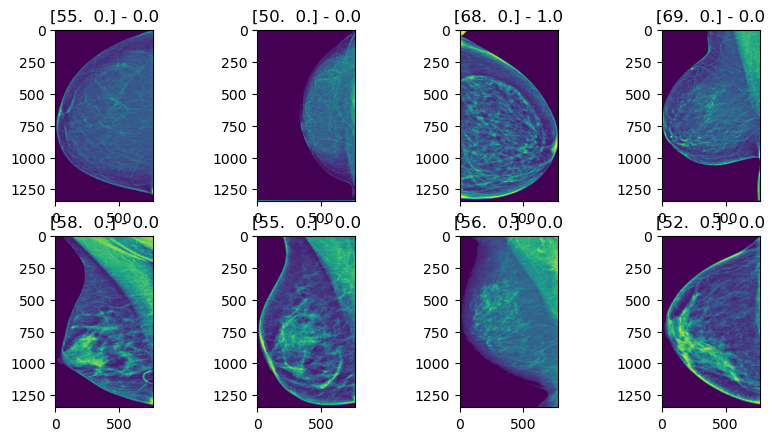

In [18]:
FNAMES_TRAIN_TFRECORDS = '/kaggle/working/nn_train_batch_0.tfrecords'
train_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=AUTO, compression_type='GZIP')
train_dataset = train_dataset.map(decode_image)
train_dataset = train_dataset.batch(8)

plt.figure(figsize=(10,5),dpi=100)
for images, target in iter(train_dataset):
    image = images[0]
    age = images[1]

    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.title(f'{age[i]} - {target[i]}')
        plt.imshow(image[i])

    break

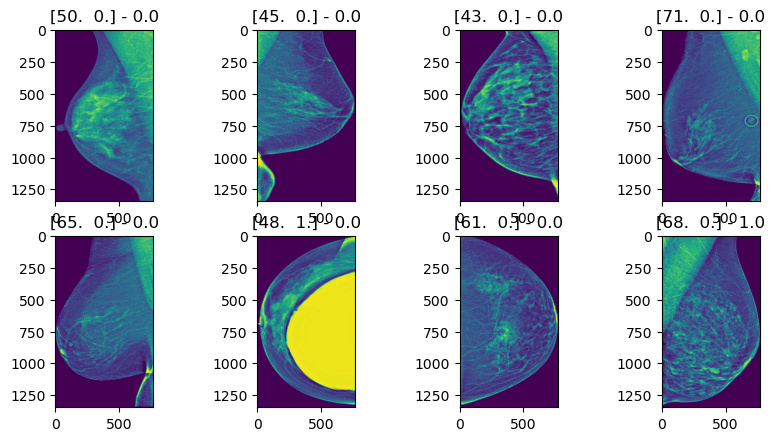

In [19]:
FNAMES_TRAIN_TFRECORDS = '/kaggle/working/nn_val_batch_0.tfrecords'
train_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=AUTO, compression_type='GZIP')
train_dataset = train_dataset.map(decode_image)
train_dataset = train_dataset.batch(8)

plt.figure(figsize=(10,5),dpi=100)
for images, target in iter(train_dataset):
    image = images[0]
    age = images[1]

    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.title(f'{age[i]} - {target[i]}')
        plt.imshow(image[i])

    break